# DQN with rated memory replay

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/aras/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
import numpy as np

state = env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action) # take a random action
    batch.append([state, action, next_state, reward, float(done)])
    #     print('state, action, reward, done, info:', 
    #           state, action, reward, done, info)
    state = next_state
    if done:
        state = env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
batch[0], batch[0][0].shape

([array([ 0.00545212, -0.00609234, -0.03893244, -0.04982415]),
  0,
  array([ 0.00533027, -0.20063503, -0.03992892,  0.23032552]),
  1.0,
  0.0],
 (4,))

In [5]:
states = np.array([each[0] for each in batch])
actions = np.array([each[1] for each in batch])
next_states = np.array([each[2] for each in batch])
rewards = np.array([each[3] for each in batch])
dones = np.array([each[4] for each in batch])

In [6]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 float64
1 0
2
1.0 1.0
2.2335040889466935 -2.757166976971607


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [7]:
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return states, actions, targetQs

In [8]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [9]:
def model_loss(states, actions, targetQs, action_size, hidden_size):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    #Qs = tf.reduce_max(actions_logits, axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
    return actions_logits, loss

In [10]:
def model_opt(loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [11]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [12]:
def sample(batch_size, ListArr):
    idx = np.random.choice(np.arange(len(ListArr)), 
                           size=batch_size, 
                           replace=True)
    return [ListArr[ii] for ii in idx]

In [13]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), 
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [15]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 24*2             # number of units in each Q-network hidden layer
learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e2)             # experience mini-batch size
gamma = 0.99                   # future reward discount

In [16]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [17]:
# Initializing the memory with the pool of random exploration of the env.
goal = 500 # env-based, the total reward required for reaching the goal G
state = env.reset() # env-based
total_reward = 0 # episode R
num_step = 0 # episode steps/ length based on number of steps
for _ in range(memory_size):
    action = env.action_space.sample() # exploring the env action space/ random action/ explore
    next_state, reward, done, _ = env.step(action) # exploring the env state, reward, and done/end
    memory.buffer.append([state, action, next_state, reward, float(done), -1])
    num_step += 1 # memory incremented
    total_reward += reward # R += r
    state = next_state # update the state for next episode
    if done is True: # end of this episode
        state = env.reset() # reset for next episode
        rate = total_reward/goal # the actual sucess rate of the played sequence
        total_reward = 0 # reset for next episode
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][5] == -1: # double-check if it is empty and it is not rated!
                memory.buffer[-1-idx][5] = rate # rate each SA pair
        num_step = 0 # reset for the next episode

In [18]:
dones = np.array(memory.buffer)[:, 4]
rates = np.array(memory.buffer)[:, 5]

In [19]:
num_step

5

In [20]:
dones[-27:]

array([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,
       0.0], dtype=object)

In [21]:
rates[-27:]

array([0.018, 0.018, 0.018, 0.018, 0.036, 0.036, 0.036, 0.036, 0.036,
       0.036, 0.036, 0.036, 0.036, 0.036, 0.036, 0.036, 0.036, 0.036,
       0.036, 0.036, 0.036, 0.036, -1, -1, -1, -1, -1], dtype=object)

In [22]:
rates = np.array(memory.buffer)[:, 5]
rated_mem = np.array(memory.buffer)[rates >= (max(rates)*0.1)]

In [23]:
rates = np.array(rated_mem)[:, 5]

In [24]:
rates

array([0.058, 0.058, 0.058, ..., 0.036, 0.036, 0.036], dtype=object)

In [25]:
# dones = np.array(memory.buffer)[:, 4]
rates = np.array(memory.buffer)[:, 5]
rated_mem = np.array(memory.buffer)[rates >= (max(rates)*0.1)]
batch = sample(ListArr=rated_mem, batch_size=batch_size)
states = np.array([each[0] for each in batch])
actions = np.array([each[1] for each in batch])
next_states = np.array([each[2] for each in batch])
rewards = np.array([each[3] for each in batch])
dones = np.array([each[4] for each in batch])
rates = np.array([each[5] for each in batch])

In [26]:
states.shape, states.dtype, actions.shape, actions.dtype, next_states.shape, next_states.dtype, \
rewards.shape, rewards.dtype, dones.shape, dones.dtype, rates.shape, rates.dtype

((100, 4),
 dtype('float64'),
 (100,),
 dtype('int64'),
 (100, 4),
 dtype('float64'),
 (100,),
 dtype('float64'),
 (100,),
 dtype('float64'),
 (100,),
 dtype('float64'))

In [27]:
rates

array([0.024, 0.042, 0.086, 0.074, 0.032, 0.026, 0.024, 0.044, 0.06 ,
       0.038, 0.108, 0.054, 0.102, 0.108, 0.088, 0.034, 0.062, 0.06 ,
       0.034, 0.068, 0.036, 0.098, 0.066, 0.044, 0.032, 0.054, 0.076,
       0.046, 0.032, 0.034, 0.034, 0.128, 0.044, 0.106, 0.058, 0.032,
       0.096, 0.154, 0.062, 0.036, 0.032, 0.036, 0.034, 0.062, 0.064,
       0.034, 0.04 , 0.026, 0.05 , 0.024, 0.032, 0.03 , 0.062, 0.12 ,
       0.128, 0.042, 0.06 , 0.034, 0.042, 0.094, 0.048, 0.032, 0.048,
       0.082, 0.17 , 0.028, 0.054, 0.05 , 0.052, 0.052, 0.062, 0.034,
       0.054, 0.12 , 0.044, 0.046, 0.082, 0.1  , 0.11 , 0.052, 0.108,
       0.044, 0.062, 0.058, 0.096, 0.036, 0.058, 0.032, 0.024, 0.03 ,
       0.022, 0.11 , 0.036, 0.028, 0.058, 0.06 , 0.024, 0.066, 0.112,
       0.036])

In [28]:
dones

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [29]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(1111):
        total_reward = 0
        loss_batch = []
        state = env.reset()
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), -1])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state

            # Rating the last played episode
            if done is True:
                rate = total_reward/ goal # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][5] == -1: # double-check if it is empty and it is not rated!
                        memory.buffer[-1-idx][5] = rate # rate each SA pair
                        
            # Rating and training the memory
            #rates = np.array(memory.buffer)[:, 5]
            #rated_mem = np.array(memory.buffer)[rates >= (max(rates)*0.1)]
            #rated_mem = np.array(memory.buffer)
            #batch = sample(ListArr=rated_mem, batch_size=batch_size)
            batch = sample(ListArr=memory.buffer, batch_size=batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            #rates = np.array([each[5] for each in batch])
            #nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            next_actions_logits = sess.run(model.actions_logits, feed_dict = {model.states: next_states})
            nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
            targetQs = rewards + (gamma * nextQs)
            loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                     model.actions: actions,
                                                                     model.targetQs: targetQs})
            loss_batch.append(loss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'loss:{:.4f}'.format(np.mean(loss_batch)),
              'exploreP:{:.4f}'.format(explore_p))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, np.mean(loss_batch)])
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:23.0000 R:23.0 rate:0.0460 loss:1.0110 exploreP:0.9977
Episode:1 meanR:42.0000 R:61.0 rate:0.1220 loss:1.1627 exploreP:0.9917
Episode:2 meanR:32.6667 R:14.0 rate:0.0280 loss:1.2473 exploreP:0.9903
Episode:3 meanR:28.2500 R:15.0 rate:0.0300 loss:1.2502 exploreP:0.9889
Episode:4 meanR:25.4000 R:14.0 rate:0.0280 loss:1.2772 exploreP:0.9875
Episode:5 meanR:24.5000 R:20.0 rate:0.0400 loss:1.3057 exploreP:0.9856
Episode:6 meanR:23.4286 R:17.0 rate:0.0340 loss:1.2722 exploreP:0.9839
Episode:7 meanR:24.5000 R:32.0 rate:0.0640 loss:1.2694 exploreP:0.9808
Episode:8 meanR:24.2222 R:22.0 rate:0.0440 loss:1.2625 exploreP:0.9787
Episode:9 meanR:24.1000 R:23.0 rate:0.0460 loss:1.2819 exploreP:0.9764
Episode:10 meanR:24.0000 R:23.0 rate:0.0460 loss:1.2919 exploreP:0.9742
Episode:11 meanR:23.1667 R:14.0 rate:0.0280 loss:1.3180 exploreP:0.9729
Episode:12 meanR:22.6154 R:16.0 rate:0.0320 loss:1.3374 exploreP:0.9713
Episode:13 meanR:23.4286 R:34.0 rate:0.0680 loss:1.3706 exploreP:0.9681
Ep

Episode:118 meanR:21.4300 R:41.0 rate:0.0820 loss:27.0601 exploreP:0.7737
Episode:119 meanR:21.3000 R:18.0 rate:0.0360 loss:34.4363 exploreP:0.7723
Episode:120 meanR:21.2000 R:14.0 rate:0.0280 loss:25.5840 exploreP:0.7713
Episode:121 meanR:21.1700 R:23.0 rate:0.0460 loss:25.6275 exploreP:0.7695
Episode:122 meanR:21.0900 R:18.0 rate:0.0360 loss:27.7654 exploreP:0.7682
Episode:123 meanR:21.0600 R:12.0 rate:0.0240 loss:20.1883 exploreP:0.7673
Episode:124 meanR:20.9500 R:16.0 rate:0.0320 loss:24.3678 exploreP:0.7660
Episode:125 meanR:20.8900 R:11.0 rate:0.0220 loss:24.6428 exploreP:0.7652
Episode:126 meanR:20.5300 R:14.0 rate:0.0280 loss:25.9233 exploreP:0.7642
Episode:127 meanR:20.5700 R:19.0 rate:0.0380 loss:27.7956 exploreP:0.7627
Episode:128 meanR:20.5500 R:30.0 rate:0.0600 loss:25.4590 exploreP:0.7605
Episode:129 meanR:20.4800 R:13.0 rate:0.0260 loss:27.3558 exploreP:0.7595
Episode:130 meanR:20.3300 R:16.0 rate:0.0320 loss:22.1399 exploreP:0.7583
Episode:131 meanR:20.7200 R:50.0 rate:

Episode:230 meanR:42.1200 R:65.0 rate:0.1300 loss:44.1791 exploreP:0.5011
Episode:231 meanR:41.8100 R:19.0 rate:0.0380 loss:42.8765 exploreP:0.5001
Episode:232 meanR:41.9800 R:35.0 rate:0.0700 loss:46.9530 exploreP:0.4984
Episode:233 meanR:42.8300 R:101.0 rate:0.2020 loss:44.2722 exploreP:0.4935
Episode:234 meanR:43.5100 R:79.0 rate:0.1580 loss:45.7844 exploreP:0.4897
Episode:235 meanR:43.9800 R:76.0 rate:0.1520 loss:46.4517 exploreP:0.4861
Episode:236 meanR:44.8400 R:108.0 rate:0.2160 loss:47.8824 exploreP:0.4810
Episode:237 meanR:45.3300 R:62.0 rate:0.1240 loss:54.4024 exploreP:0.4781
Episode:238 meanR:45.7600 R:67.0 rate:0.1340 loss:53.8842 exploreP:0.4749
Episode:239 meanR:46.3900 R:97.0 rate:0.1940 loss:48.9768 exploreP:0.4705
Episode:240 meanR:46.3500 R:33.0 rate:0.0660 loss:63.7741 exploreP:0.4689
Episode:241 meanR:46.3900 R:22.0 rate:0.0440 loss:46.6550 exploreP:0.4679
Episode:242 meanR:46.5500 R:48.0 rate:0.0960 loss:57.1289 exploreP:0.4657
Episode:243 meanR:46.6600 R:26.0 rat

Episode:339 meanR:142.0200 R:212.0 rate:0.4240 loss:747.5423 exploreP:0.1213
Episode:340 meanR:143.1500 R:146.0 rate:0.2920 loss:730.9006 exploreP:0.1197
Episode:341 meanR:145.0100 R:208.0 rate:0.4160 loss:869.4290 exploreP:0.1174
Episode:342 meanR:146.8800 R:235.0 rate:0.4700 loss:865.1468 exploreP:0.1149
Episode:343 meanR:149.5600 R:294.0 rate:0.5880 loss:860.9126 exploreP:0.1119
Episode:344 meanR:150.6800 R:188.0 rate:0.3760 loss:942.5366 exploreP:0.1100
Episode:345 meanR:152.2000 R:216.0 rate:0.4320 loss:990.5001 exploreP:0.1078
Episode:346 meanR:155.0800 R:349.0 rate:0.6980 loss:920.1990 exploreP:0.1045
Episode:347 meanR:156.6200 R:222.0 rate:0.4440 loss:995.1941 exploreP:0.1024
Episode:348 meanR:157.3200 R:173.0 rate:0.3460 loss:1145.0999 exploreP:0.1008
Episode:349 meanR:159.1500 R:262.0 rate:0.5240 loss:1111.7498 exploreP:0.0985
Episode:350 meanR:161.7200 R:378.0 rate:0.7560 loss:1158.4052 exploreP:0.0952
Episode:351 meanR:164.5000 R:328.0 rate:0.6560 loss:1362.4403 exploreP:0.

Episode:444 meanR:315.7100 R:338.0 rate:0.6760 loss:17895.2969 exploreP:0.0143
Episode:445 meanR:316.2300 R:268.0 rate:0.5360 loss:19739.8730 exploreP:0.0141
Episode:446 meanR:316.1100 R:337.0 rate:0.6740 loss:19222.6133 exploreP:0.0140
Episode:447 meanR:317.2000 R:331.0 rate:0.6620 loss:18835.5742 exploreP:0.0139
Episode:448 meanR:320.2300 R:476.0 rate:0.9520 loss:18272.7266 exploreP:0.0137
Episode:449 meanR:321.0700 R:346.0 rate:0.6920 loss:19757.1562 exploreP:0.0136
Episode:450 meanR:320.2900 R:300.0 rate:0.6000 loss:17963.0000 exploreP:0.0135
Episode:451 meanR:320.3900 R:338.0 rate:0.6760 loss:18500.0020 exploreP:0.0133
Episode:452 meanR:320.8400 R:247.0 rate:0.4940 loss:20101.9805 exploreP:0.0133
Episode:453 meanR:320.3400 R:246.0 rate:0.4920 loss:18016.3691 exploreP:0.0132
Episode:454 meanR:320.6900 R:261.0 rate:0.5220 loss:17823.4023 exploreP:0.0131
Episode:455 meanR:319.0800 R:239.0 rate:0.4780 loss:17118.2070 exploreP:0.0130
Episode:456 meanR:319.4500 R:500.0 rate:1.0000 loss:

Episode:548 meanR:263.2100 R:179.0 rate:0.3580 loss:186634.6875 exploreP:0.0103
Episode:549 meanR:261.6400 R:189.0 rate:0.3780 loss:185840.7969 exploreP:0.0103
Episode:550 meanR:261.6700 R:303.0 rate:0.6060 loss:189457.1406 exploreP:0.0103
Episode:551 meanR:260.3500 R:206.0 rate:0.4120 loss:193226.3906 exploreP:0.0102
Episode:552 meanR:260.6600 R:278.0 rate:0.5560 loss:197211.5000 exploreP:0.0102
Episode:553 meanR:260.0100 R:181.0 rate:0.3620 loss:204399.2500 exploreP:0.0102
Episode:554 meanR:259.0700 R:167.0 rate:0.3340 loss:195664.1406 exploreP:0.0102
Episode:555 meanR:258.3500 R:167.0 rate:0.3340 loss:225089.2031 exploreP:0.0102
Episode:556 meanR:255.4400 R:209.0 rate:0.4180 loss:220413.6406 exploreP:0.0102
Episode:557 meanR:255.0200 R:184.0 rate:0.3680 loss:221385.5625 exploreP:0.0102
Episode:558 meanR:254.1500 R:203.0 rate:0.4060 loss:228963.1094 exploreP:0.0102
Episode:559 meanR:251.5800 R:243.0 rate:0.4860 loss:227280.6562 exploreP:0.0102
Episode:560 meanR:251.1400 R:145.0 rate:

Episode:650 meanR:264.5300 R:500.0 rate:1.0000 loss:6082509.0000 exploreP:0.0100
Episode:651 meanR:267.4700 R:500.0 rate:1.0000 loss:6222932.0000 exploreP:0.0100
Episode:652 meanR:269.6900 R:500.0 rate:1.0000 loss:6394689.5000 exploreP:0.0100
Episode:653 meanR:272.8800 R:500.0 rate:1.0000 loss:6525284.5000 exploreP:0.0100
Episode:654 meanR:276.2100 R:500.0 rate:1.0000 loss:6686705.5000 exploreP:0.0100
Episode:655 meanR:279.5400 R:500.0 rate:1.0000 loss:6736316.5000 exploreP:0.0100
Episode:656 meanR:282.4500 R:500.0 rate:1.0000 loss:6933025.0000 exploreP:0.0100
Episode:657 meanR:285.6100 R:500.0 rate:1.0000 loss:7126012.0000 exploreP:0.0100
Episode:658 meanR:288.5800 R:500.0 rate:1.0000 loss:7288871.5000 exploreP:0.0100
Episode:659 meanR:291.1500 R:500.0 rate:1.0000 loss:7524361.0000 exploreP:0.0100
Episode:660 meanR:294.7000 R:500.0 rate:1.0000 loss:7570449.0000 exploreP:0.0100
Episode:661 meanR:297.2800 R:500.0 rate:1.0000 loss:7650125.0000 exploreP:0.0100
Episode:662 meanR:300.2500 R

Episode:751 meanR:424.2900 R:500.0 rate:1.0000 loss:6659279.5000 exploreP:0.0100
Episode:752 meanR:424.2900 R:500.0 rate:1.0000 loss:6340424.0000 exploreP:0.0100
Episode:753 meanR:424.2900 R:500.0 rate:1.0000 loss:6118768.5000 exploreP:0.0100
Episode:754 meanR:424.2900 R:500.0 rate:1.0000 loss:6132458.5000 exploreP:0.0100
Episode:755 meanR:424.2900 R:500.0 rate:1.0000 loss:5978562.0000 exploreP:0.0100
Episode:756 meanR:424.2900 R:500.0 rate:1.0000 loss:6022868.0000 exploreP:0.0100
Episode:757 meanR:424.2900 R:500.0 rate:1.0000 loss:5808436.0000 exploreP:0.0100
Episode:758 meanR:424.2900 R:500.0 rate:1.0000 loss:5827917.5000 exploreP:0.0100
Episode:759 meanR:424.2900 R:500.0 rate:1.0000 loss:6214890.5000 exploreP:0.0100
Episode:760 meanR:424.2900 R:500.0 rate:1.0000 loss:7201981.0000 exploreP:0.0100
Episode:761 meanR:423.8600 R:457.0 rate:0.9140 loss:6277306.5000 exploreP:0.0100
Episode:762 meanR:422.8600 R:400.0 rate:0.8000 loss:6209166.5000 exploreP:0.0100
Episode:763 meanR:421.8800 R

Episode:853 meanR:250.8600 R:293.0 rate:0.5860 loss:4057803.5000 exploreP:0.0100
Episode:854 meanR:248.5200 R:266.0 rate:0.5320 loss:4056832.0000 exploreP:0.0100
Episode:855 meanR:243.6200 R:10.0 rate:0.0200 loss:3273521.0000 exploreP:0.0100
Episode:856 meanR:238.7200 R:10.0 rate:0.0200 loss:4143142.0000 exploreP:0.0100
Episode:857 meanR:233.8100 R:9.0 rate:0.0180 loss:4718422.5000 exploreP:0.0100
Episode:858 meanR:228.8900 R:8.0 rate:0.0160 loss:3756004.0000 exploreP:0.0100
Episode:859 meanR:223.9800 R:9.0 rate:0.0180 loss:4080178.2500 exploreP:0.0100
Episode:860 meanR:219.0600 R:8.0 rate:0.0160 loss:3006525.0000 exploreP:0.0100
Episode:861 meanR:214.5900 R:10.0 rate:0.0200 loss:3628790.0000 exploreP:0.0100
Episode:862 meanR:210.6800 R:9.0 rate:0.0180 loss:4621986.5000 exploreP:0.0100
Episode:863 meanR:206.7500 R:9.0 rate:0.0180 loss:4062647.5000 exploreP:0.0100
Episode:864 meanR:203.6700 R:9.0 rate:0.0180 loss:4122968.5000 exploreP:0.0100
Episode:865 meanR:200.5300 R:11.0 rate:0.0220

Episode:960 meanR:16.0600 R:12.0 rate:0.0240 loss:3401676.7500 exploreP:0.0100
Episode:961 meanR:16.0900 R:13.0 rate:0.0260 loss:2809505.2500 exploreP:0.0100
Episode:962 meanR:16.1300 R:13.0 rate:0.0260 loss:3028194.2500 exploreP:0.0100
Episode:963 meanR:16.1600 R:12.0 rate:0.0240 loss:2997828.2500 exploreP:0.0100
Episode:964 meanR:16.1800 R:11.0 rate:0.0220 loss:3762845.7500 exploreP:0.0100
Episode:965 meanR:16.1900 R:12.0 rate:0.0240 loss:3419491.2500 exploreP:0.0100
Episode:966 meanR:16.2200 R:12.0 rate:0.0240 loss:2885849.7500 exploreP:0.0100
Episode:967 meanR:16.2600 R:13.0 rate:0.0260 loss:3195573.2500 exploreP:0.0100
Episode:968 meanR:16.2700 R:11.0 rate:0.0220 loss:2297481.7500 exploreP:0.0100
Episode:969 meanR:16.2900 R:13.0 rate:0.0260 loss:3548245.0000 exploreP:0.0100
Episode:970 meanR:16.3200 R:12.0 rate:0.0240 loss:3141756.7500 exploreP:0.0100
Episode:971 meanR:16.3500 R:13.0 rate:0.0260 loss:3180931.0000 exploreP:0.0100
Episode:972 meanR:16.3600 R:11.0 rate:0.0220 loss:31

Episode:1063 meanR:114.2600 R:500.0 rate:1.0000 loss:2448441.7500 exploreP:0.0100
Episode:1064 meanR:118.1400 R:399.0 rate:0.7980 loss:2411065.5000 exploreP:0.0100
Episode:1065 meanR:123.0200 R:500.0 rate:1.0000 loss:2368356.2500 exploreP:0.0100
Episode:1066 meanR:125.3800 R:248.0 rate:0.4960 loss:2411209.2500 exploreP:0.0100
Episode:1067 meanR:130.2500 R:500.0 rate:1.0000 loss:2299520.0000 exploreP:0.0100
Episode:1068 meanR:135.1400 R:500.0 rate:1.0000 loss:2153444.2500 exploreP:0.0100
Episode:1069 meanR:139.3200 R:431.0 rate:0.8620 loss:2053801.2500 exploreP:0.0100
Episode:1070 meanR:142.4100 R:321.0 rate:0.6420 loss:2084761.1250 exploreP:0.0100
Episode:1071 meanR:147.2800 R:500.0 rate:1.0000 loss:2067261.2500 exploreP:0.0100
Episode:1072 meanR:150.2700 R:310.0 rate:0.6200 loss:1988757.8750 exploreP:0.0100
Episode:1073 meanR:153.4300 R:328.0 rate:0.6560 loss:1916743.0000 exploreP:0.0100
Episode:1074 meanR:157.1000 R:380.0 rate:0.7600 loss:1829566.6250 exploreP:0.0100
Episode:1075 mea

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [202]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

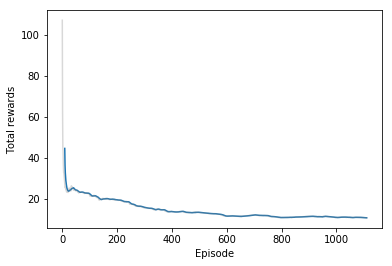

In [203]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

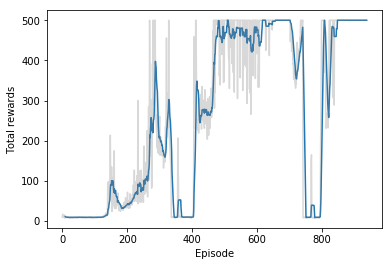

In [24]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Average losses')

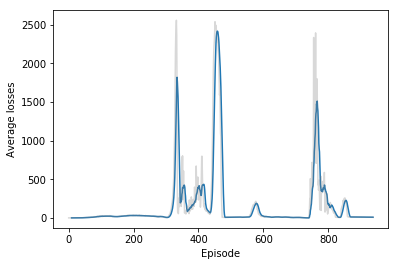

In [25]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
# Creating a gym env
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

# A training graph session
with tf.Session(graph=graph) as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {}'.format(total_reward))
# Close the env at the end
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.